In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, zipfile, glob, re, shutil

zip_path    = '/content/drive/MyDrive/NASA Space apps/kepler.zip'
extract_dir = '/content/kepler_data'

# Wipe and re-create the extract dir (forces a fresh unzip)
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

# Peek inside the zip first (how many FITS vs FITS.GZ are in it?)
with zipfile.ZipFile(zip_path, 'r') as zf:
    names = zf.namelist()
    n_fits    = sum(n.lower().endswith('.fits')     for n in names)
    n_fits_gz = sum(n.lower().endswith('.fits.gz')  for n in names)
    print(f"Inside ZIP -> .fits: {n_fits}, .fits.gz: {n_fits_gz}, total: {n_fits + n_fits_gz}")

# Extract everything
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_dir)

print("Top-level extracted to:", extract_dir)


Inside ZIP -> .fits: 3800, .fits.gz: 0, total: 3800
Top-level extracted to: /content/kepler_data


In [3]:
# If there are *.zip files inside the extracted tree, unpack them next to themselves
nested_zips = glob.glob(os.path.join(extract_dir, '**', '*.zip'), recursive=True)
print("Nested zip files found:", len(nested_zips))
for zp in nested_zips:
    try:
        with zipfile.ZipFile(zp, 'r') as zf:
            zf.extractall(os.path.dirname(zp))
    except Exception as e:
        print("Could not extract nested:", zp, e)


Nested zip files found: 0


In [4]:
# Find all FITS variants (case-insensitive)
patterns = ('*.fits', '*.FITS', '*.fits.gz', '*.FITS.GZ')
fits_files = sorted(set(
    p for pat in patterns for p in glob.glob(os.path.join(extract_dir, '**', pat), recursive=True)
))
csv_files  = sorted(glob.glob(os.path.join(extract_dir, '**', '*.csv'), recursive=True))

print(f"Found {len(fits_files)} FITS (including .fits.gz) and {len(csv_files)} CSV files.")
# Quick breakdown:
n_fits    = sum(p.lower().endswith('.fits') for p in fits_files)
n_fits_gz = sum(p.lower().endswith('.fits.gz') for p in fits_files)
print(f"  breakdown -> .fits: {n_fits}, .fits.gz: {n_fits_gz}")


Found 3800 FITS (including .fits.gz) and 1 CSV files.
  breakdown -> .fits: 3800, .fits.gz: 0


In [5]:
import pandas as pd
import numpy as np

CSV_PATH = '/content/kepler_data/kepler_lightcurves/kepler_lc_status.csv'  # adjust if yours is elsewhere
labels = pd.read_csv(CSV_PATH)

# Build a lookup that maps BOTH "name.fits" and "name.fits.gz" to the same path
base_to_path = {}
for p in fits_files:
    base = os.path.basename(p).lower()
    base_to_path[base] = p
    if base.endswith('.fits.gz'):
        base_to_path[base[:-3]] = p  # also map the .fits version to the same file

# Normalize CSV filenames
labels['__product_base__']  = labels['productFilename'].astype(str).str.strip().str.lower()
labels['__product_base2__'] = labels['__product_base__'].str.replace(r'\.gz$', '', regex=True)

# First pass: by normalized filename
labels['fits_path']  = labels['__product_base__'].map(base_to_path)
miss_mask            = labels['fits_path'].isna()
labels.loc[miss_mask, 'fits_path'] = labels.loc[miss_mask, '__product_base2__'].map(base_to_path)

# Second pass: fallback by KepID pattern in filename (kplr#########)
def kepid_from_name(s):
    s = str(s).lower()
    m = re.search(r'kplr(\d{9})', s)
    return int(m.group(1)) if m else np.nan

labels['kepid_norm'] = labels.get('kepid', np.nan)
try:
    labels['kepid_norm'] = labels['kepid_norm'].astype('Int64')
except Exception:
    labels['kepid_norm'] = pd.Series([np.nan]*len(labels), dtype='float')

miss = labels['fits_path'].isna()
if miss.any():
    # Create a quick index: kepid -> one best path (prefer _llc over _slc)
    cat = pd.DataFrame({
        'path': fits_files,
        'base': [os.path.basename(p).lower() for p in fits_files]
    })
    cat['kepid_from_name'] = cat['base'].apply(lambda b: int(re.search(r'kplr(\d{9})', b).group(1)) if re.search(r'kplr(\d{9})', b) else np.nan)
    cat['is_llc'] = cat['base'].str.endswith('_llc.fits') | cat['base'].str.endswith('_llc.fits.gz')
    # choose 1 path per kepid, preferring LLC
    kepid_best = (cat.dropna(subset=['kepid_from_name'])
                    .sort_values(['kepid_from_name','is_llc'], ascending=[True, False])
                    .drop_duplicates('kepid_from_name'))
    kepid_map = dict(zip(kepid_best['kepid_from_name'].astype(int), kepid_best['path']))

    # Where CSV has kepid AND we still missed filename, map by kepid
    can_map = miss & labels['kepid_norm'].notna()
    labels.loc[can_map, 'fits_path'] = labels.loc[can_map, 'kepid_norm'].astype(int).map(kepid_map)

matched = labels['fits_path'].notna().sum()
print(f"Matched {matched}/{len(labels)} CSV rows to actual files on disk.")
if matched < len(labels):
    print("Examples still unmatched:")
    print(labels.loc[labels['fits_path'].isna(), ['productFilename','kepid']].head(8))


Matched 3800/3800 CSV rows to actual files on disk.


In [6]:
from astropy.io import fits
import re

def load_all_labels(csv_paths):
    """Read every CSV label file and concatenate with a source marker."""
    frames = []
    for p in csv_paths:
        try:
            df = pd.read_csv(p)
            df['__source_csv__'] = p
            frames.append(df)
        except Exception as e:
            print(f'Could not read {p}: {e}')
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def build_fits_index(fits_paths):
    """
    Build a table mapping each FITS path to an object_id guessed from header
    (KEPLERID/KICID/TICID/OBJECT/TARGET) or from the filename digits.
    """
    rows = []
    for p in fits_paths:
        oid = None
        try:
            with fits.open(p, memmap=False) as hdul:
                h0 = hdul[0].header
                for key in ['KEPLERID','KICID','TICID','OBJECT','TARGET']:
                    if key in h0:
                        oid = str(h0[key])
                        break
        except Exception:
            pass

        if oid is None:
            base = os.path.basename(p)
            m = re.search(r'(\d{5,})', base)
            oid = m.group(1) if m else base

        rows.append({'object_id': str(oid), 'fits_path': p})
    return pd.DataFrame(rows)

labels = load_all_labels(csv_files)
print(f'Labels shape: {labels.shape}')
display(labels.head() if not labels.empty else "No label CSVs found.")

fits_index = build_fits_index(fits_files)
print(f'FITS index shape: {fits_index.shape}')
display(fits_index.head())


Labels shape: (3800, 9)


,productFilename,dataURI,target_name,kepid,koi_names,koi_dispositions,status_best,is_confirmed,__source_csv__
0,kplr005772623-2009131105131_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,5772623,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
1,kplr006203700-2009166043257_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
2,kplr006203700-2009259160929_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
3,kplr006203700-2009350155506_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
4,kplr006203700-2010078095331_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...


FITS index shape: (3800, 2)


,object_id,fits_path
0,1429345,/content/kepler_data/kepler_lightcurves/kplr00...
1,1429345,/content/kepler_data/kepler_lightcurves/kplr00...
2,1429345,/content/kepler_data/kepler_lightcurves/kplr00...
3,1429345,/content/kepler_data/kepler_lightcurves/kplr00...
4,1429345,/content/kepler_data/kepler_lightcurves/kplr00...


In [7]:
def try_join(fits_index, labels):
    if labels.empty:
        print('No labels to join; using FITS index only.')
        return fits_index

    # Heuristic list of likely key columns in labels
    likely = ['kepid','kepler_id','kic','kicid','tic','ticid','object',
              'object_id','target','filename','file','id','ID']

    # Gather candidate keys (include numeric columns as fallbacks)
    candidate_keys = [c for c in labels.columns if c.lower() in [x.lower() for x in likely]]
    for c in labels.columns:
        if labels[c].dtype.kind in 'iuf' and c not in candidate_keys:
            candidate_keys.append(c)

    # Normalize FITS object_id -> 'key'
    left = fits_index.copy()
    left['key'] = left['object_id'].astype(str).str.extract(r'(\d+)').fillna(left['object_id']).iloc[:,0]

    # Try each candidate until we get reasonable hit rate
    best = None
    best_rate = -1
    for key in candidate_keys:
        right = labels.copy()
        # Normalize label key to string digits if present
        if right[key].dtype.kind in 'f':
            # avoid '1234.0'
            right['key'] = right[key].astype('Int64').astype(str)
        else:
            right['key'] = right[key].astype(str).str.extract(r'(\d+)').fillna(right[key].astype(str)).iloc[:,0]

        merged = left.merge(right, on='key', how='left', suffixes=('','_lbl'))
        rate = merged['__source_csv__'].notna().mean() if '__source_csv__' in merged.columns else 0
        if rate > best_rate:
            best, best_rate, best_key = merged, rate, key

    if best_rate > 0:
        print(f'Guessed join on label column "{best_key}" — matched {best_rate:.0%} of FITS.')
        return best.drop(columns=['key'])
    else:
        print('No obvious join key found; returning un-joined FITS index.')
        return fits_index

dataset_index = try_join(fits_index, labels)
print('dataset_index columns:', list(dataset_index.columns))
display(dataset_index.head())


Guessed join on label column "kepid" — matched 100% of FITS.
dataset_index columns: ['object_id', 'fits_path', 'productFilename', 'dataURI', 'target_name', 'kepid', 'koi_names', 'koi_dispositions', 'status_best', 'is_confirmed', '__source_csv__']


,object_id,fits_path,productFilename,dataURI,target_name,kepid,koi_names,koi_dispositions,status_best,is_confirmed,__source_csv__
0,1429345,/content/kepler_data/kepler_lightcurves/kplr00...,kplr001429345-2009166043257_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,1429345,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
1,1429345,/content/kepler_data/kepler_lightcurves/kplr00...,kplr001429345-2009259160929_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,1429345,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
2,1429345,/content/kepler_data/kepler_lightcurves/kplr00...,kplr001429345-2009350155506_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,1429345,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
3,1429345,/content/kepler_data/kepler_lightcurves/kplr00...,kplr001429345-2010078095331_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,1429345,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
4,1429345,/content/kepler_data/kepler_lightcurves/kplr00...,kplr001429345-2010174085026_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,1429345,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...


In [8]:
def read_lightcurve(fits_path, prefer='PDCSAP_FLUX'):
    """
    Returns a dict with:
      object_id, time, flux, flux_err, quality, path, columns (found in LC table), meta (primary header)
    Chooses PDCSAP_FLUX if available, else SAP_FLUX, else any *FLUX column.
    Filters non-finite and (if present) QUALITY != 0.
    """

    with fits.open(fits_path, memmap=False) as hdul:
        # Find first table HDU with TIME column
        lc_hdu = None
        for hdu in hdul:
            if hasattr(hdu, 'data') and getattr(hdu, 'data', None) is not None and isinstance(hdu, fits.BinTableHDU):
                try:
                    colnames = [c.name.upper() for c in hdu.columns]
                except Exception:
                    continue
                if 'TIME' in colnames:
                    lc_hdu = hdu
                    break
        if lc_hdu is None:
            raise ValueError(f'No time-series table found in {fits_path}')

        cols = {c.name.upper(): c.name for c in lc_hdu.columns}

        time = np.array(lc_hdu.data[cols['TIME']], dtype='float64')

        # Flux choice preference
        flux_col = None
        for c in [prefer, f'{prefer}_CORR', 'PDCSAP_FLUX', 'SAP_FLUX', 'FLUX']:
            if c in cols:
                flux_col = cols[c]; break
        if flux_col is None:
            # pick any column containing 'FLUX'
            flux_like = [n for n in cols if 'FLUX' in n]
            if flux_like: flux_col = cols[flux_like[0]]
        if flux_col is None:
            raise ValueError(f'No flux-like column found in {fits_path}')

        flux = np.array(lc_hdu.data[flux_col], dtype='float64')

        # Optional error and quality
        err = None
        for cand in [flux_col + '_ERR', 'PDCSAP_FLUX_ERR', 'SAP_FLUX_ERR', 'FLUX_ERR', 'ERR']:
            if cand in cols:
                err = np.array(lc_hdu.data[cols[cand]], dtype='float64'); break
        quality = None
        if 'QUALITY' in cols:
            quality = np.array(lc_hdu.data[cols['QUALITY']], dtype='int64')

        # Metadata & object id
        hdr = dict(hdul[0].header)
        object_id = None
        for key in ['KEPLERID','KICID','TICID','OBJECT','TARGET']:
            if key in hdr:
                object_id = str(hdr[key]); break
        if object_id is None:
            object_id = os.path.basename(fits_path)

    mask = np.isfinite(time) & np.isfinite(flux)
    if quality is not None:
        try:
            mask &= (quality == 0)
        except Exception:
            pass

    return {
        'object_id': object_id,
        'time': time[mask],
        'flux': flux[mask],
        'flux_err': None if err is None else err[mask],
        'quality': None if quality is None else quality[mask],
        'path': fits_path,
        'columns': list(cols.keys()),
        'meta': hdr,
    }


dataset_index has columns: ['object_id', 'fits_path', 'productFilename', 'dataURI', 'target_name', 'kepid', 'koi_names', 'koi_dispositions', 'status_best', 'is_confirmed', '__source_csv__']


,object_id,fits_path,productFilename,dataURI,target_name,kepid,koi_names,koi_dispositions,status_best,is_confirmed,__source_csv__
34772,8323466,/content/kepler_data/kepler_lightcurves/kplr00...,kplr008323466-2009259160929_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,8323466,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
4124,3832474,/content/kepler_data/kepler_lightcurves/kplr00...,kplr003832474-2011208035123_slc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,3832474,K00806.01;K00806.02;K00806.03;K00806.04;K00806.05,CONFIRMED;FALSE POSITIVE,CONFIRMED,True,/content/kepler_data/kepler_lightcurves/kepler...
31732,8013515,/content/kepler_data/kepler_lightcurves/kplr00...,kplr008013515-2009259160929_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,8013515,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
50969,10657750,/content/kepler_data/kepler_lightcurves/kplr01...,kplr010657750-2012277125453_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/01...,NaN,10657750,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...
41389,9335348,/content/kepler_data/kepler_lightcurves/kplr00...,kplr009335348-2012179063303_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,9335348,NaN,NaN,NONE,False,/content/kepler_data/kepler_lightcurves/kepler...


Sample FITS: /content/kepler_data/kepler_lightcurves/kplr001429345-2009166043257_llc.fits
FITS LC columns found: ['TIME', 'TIMECORR', 'CADENCENO', 'SAP_FLUX', 'SAP_FLUX_ERR', 'SAP_BKG', 'SAP_BKG_ERR', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR', 'SAP_QUALITY', 'PSF_CENTR1', 'PSF_CENTR1_ERR', 'PSF_CENTR2', 'PSF_CENTR2_ERR', 'MOM_CENTR1', 'MOM_CENTR1_ERR', 'MOM_CENTR2', 'MOM_CENTR2_ERR', 'POS_CORR1', 'POS_CORR2']
Object ID: 1429345
N points: 1624


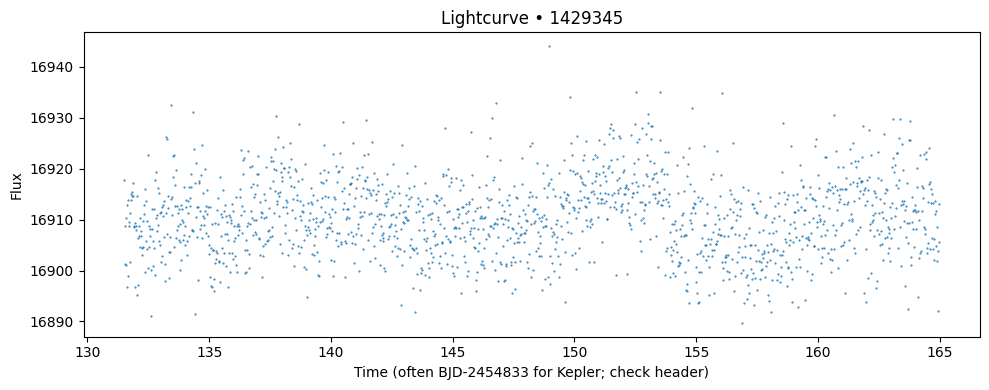

In [9]:
# Peek the overall structure
print('dataset_index has columns:', list(dataset_index.columns))
display(dataset_index.sample(min(5, len(dataset_index))) if len(dataset_index) else dataset_index)

# Load one sample FITS and plot
import matplotlib.pyplot as plt

if len(dataset_index):
    sample_path = dataset_index['fits_path'].iloc[0]
    sample = read_lightcurve(sample_path)

    print('Sample FITS:', sample_path)
    print('FITS LC columns found:', sample['columns'])
    print('Object ID:', sample['object_id'])
    print('N points:', len(sample['time']))

    plt.figure(figsize=(10,4))
    plt.plot(sample['time'], sample['flux'], '.', markersize=1)
    plt.xlabel('Time (often BJD-2454833 for Kepler; check header)')
    plt.ylabel('Flux')
    plt.title(f'Lightcurve • {sample["object_id"]}')
    plt.tight_layout()
    plt.show()
else:
    print('No FITS files found to plot.')


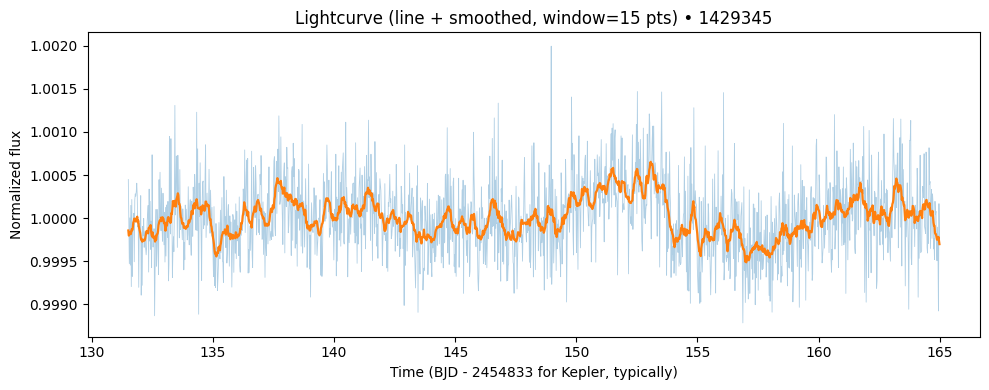

Median cadence ≈ 0.02043 days, smoothing window = 15 points (~0.31 days).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def smooth_moving_average(y, window_pts=11):
    """Centered moving average that handles NaNs gracefully."""
    window_pts = int(max(3, window_pts))
    if window_pts % 2 == 0:  # prefer odd window for centered smoothing
        window_pts += 1
    return pd.Series(y).rolling(window_pts, center=True, min_periods=max(1, window_pts//2)).mean().to_numpy()

def segment_by_gaps(x, max_gap=None):
    """Split index array where time gaps are large to avoid misleading lines."""
    if len(x) < 2:
        return [np.arange(len(x))]
    dx = np.diff(x)
    if max_gap is None:
        # treat anything > 5× median cadence as a gap
        med = np.nanmedian(dx) if np.isfinite(dx).any() else 0
        max_gap = 5 * med if med > 0 else np.inf
    breaks = np.where(dx > max_gap)[0] + 1
    return np.split(np.arange(len(x)), breaks)

# ---- Load one sample ----
sample_path = dataset_index['fits_path'].iloc[0]
sample = read_lightcurve(sample_path)
t = sample['time']
f = sample['flux']

# Normalize (keeps units tidy for plotting)
f = f / np.nanmedian(f)

# Pick a small smoothing scale automatically (~0.3 day span by default)
target_span_days = 0.3
cad = np.nanmedian(np.diff(t)) if len(t) > 1 else np.nan
if np.isfinite(cad) and cad > 0:
    window_pts = int(round(target_span_days / cad))
else:
    window_pts = 11
window_pts = max(5, window_pts | 1)  # odd & not too small

f_smooth = smooth_moving_average(f, window_pts=window_pts)

# ---- Plot: raw (faint) + smoothed line, broken at gaps ----
plt.figure(figsize=(10, 4))

# raw line (light)
for idx in segment_by_gaps(t):
    if len(idx) > 1:
        plt.plot(t[idx], f[idx], linewidth=0.6, alpha=0.35)

# smoothed line (emphasis)
for idx in segment_by_gaps(t):
    if len(idx) > 1:
        plt.plot(t[idx], f_smooth[idx], linewidth=1.6)

plt.xlabel('Time (BJD - 2454833 for Kepler, typically)')
plt.ylabel('Normalized flux')
plt.title(f'Lightcurve (line + smoothed, window={window_pts} pts) • {sample["object_id"]}')
plt.tight_layout()
plt.show()

print(f"Median cadence ≈ {cad:.5f} days, smoothing window = {window_pts} points "
      f"(~{window_pts * cad:.2f} days).")


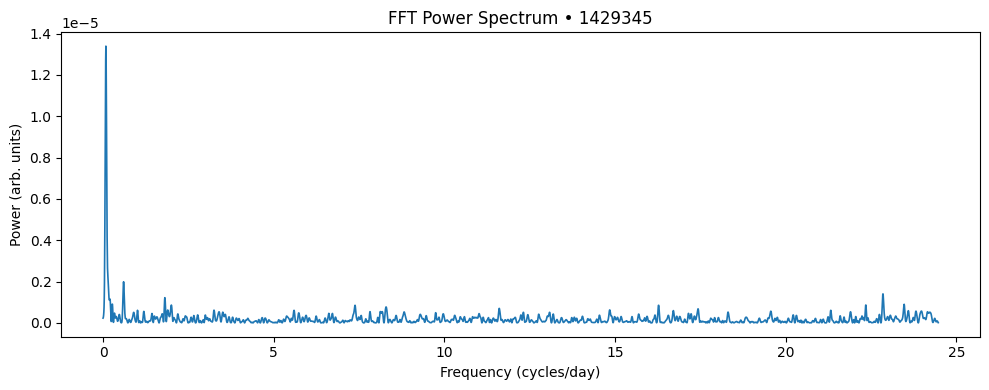

Top peaks (cycles/day) and (~microHz):
  f =    0.6033 c/d  (~    6.98 μHz) | power = 1.99e-06
  f =    0.5974 c/d  (~    6.91 μHz) | power = 1.94e-06
  f =    0.6093 c/d  (~    7.05 μHz) | power = 1.87e-06
  f =    0.5914 c/d  (~    6.84 μHz) | power = 1.74e-06
  f =    0.6153 c/d  (~    7.12 μHz) | power = 1.62e-06


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- tiny helpers ---
def next_pow_two(n):
    return 1 << int(np.ceil(np.log2(max(2, n))))

def ensure_segment_by_gaps():
    # Reuse if you already defined it; otherwise define a simple version.
    try:
        segment_by_gaps  # noqa: F821
        return segment_by_gaps
    except NameError:
        def segment_by_gaps(x, max_gap=None):
            x = np.asarray(x)
            if len(x) < 2:
                return [np.arange(len(x))]
            dx = np.diff(x)
            if max_gap is None:
                med = np.nanmedian(dx) if np.isfinite(dx).any() else 0
                max_gap = 5 * med if med > 0 else np.inf
            breaks = np.where(dx > max_gap)[0] + 1
            return np.split(np.arange(len(x)), breaks)
        return segment_by_gaps

segment_by_gaps = ensure_segment_by_gaps()

def welch_like_fft(t, y, min_pts=128, pad_factor=4):
    """
    FFT on uneven time series by:
      1) splitting at big gaps,
      2) per-segment: detrend (demean), Hann window, zero-pad,
      3) rFFT -> power; interpolate to a common frequency grid,
      4) average power across segments (Welch-like).
    Returns (freq_cpd, power), where freq is in cycles/day.
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    # remove NaNs
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]
    if t.size < min_pts:
        raise ValueError("Not enough points for FFT.")

    # segments to avoid bridging big gaps
    segs = [idx for idx in segment_by_gaps(t) if idx.size >= min_pts]
    if not segs:
        raise ValueError("No segment has enough contiguous points for FFT.")

    # choose a common freq grid based on the *median* cadence and segment length
    all_dts = []
    seg_lengths = []
    for idx in segs:
        if idx.size > 1:
            all_dts.append(np.nanmedian(np.diff(t[idx])))
            seg_lengths.append(idx.size)
    dt_med = float(np.nanmedian(all_dts)) if all_dts else np.nan
    if not np.isfinite(dt_med) or dt_med <= 0:
        raise ValueError("Could not determine a reasonable cadence.")
    n_med = int(np.median(seg_lengths))
    nfft_common = next_pow_two(n_med * pad_factor)
    freq_common = np.fft.rfftfreq(nfft_common, d=dt_med)  # cycles/day

    power_acc = np.zeros_like(freq_common)
    count_acc = np.zeros_like(freq_common)

    for idx in segs:
        tt = t[idx]
        yy = y[idx]

        # Detrend: median-normalize and zero-mean
        med = np.nanmedian(yy)
        if np.isfinite(med) and med != 0:
            yy = yy / med - 1.0
        yy = yy - np.nanmean(yy)

        # Window
        n = tt.size
        w = np.hanning(n)
        yyw = yy * w

        # Segment cadence & nfft
        dt = np.nanmedian(np.diff(tt))
        if not np.isfinite(dt) or dt <= 0:
            continue
        nfft = next_pow_two(n * pad_factor)

        # rFFT
        Y = np.fft.rfft(yyw, n=nfft)
        # Window power to keep units sensible (arbitrary overall scale)
        U = (w**2).sum()
        power = (np.abs(Y)**2) / max(U, 1e-12)

        # Frequencies for this segment
        fseg = np.fft.rfftfreq(nfft, d=dt)  # cycles/day

        # Interpolate power onto common grid (ignore extrapolated edges)
        left = fseg[0]; right = fseg[-1]
        mask = (freq_common >= left) & (freq_common <= right)
        if mask.any():
            power_interp = np.interp(freq_common[mask], fseg, power)
            power_acc[mask] += power_interp
            count_acc[mask] += 1

    used = count_acc > 0
    if not used.any():
        raise ValueError("No overlapping frequency support across segments.")
    power_avg = np.zeros_like(power_acc)
    power_avg[used] = power_acc[used] / count_acc[used]

    return freq_common[used], power_avg[used]

# --- Load a sample and compute FFT ---
sample_path = dataset_index['fits_path'].iloc[0]
sample = read_lightcurve(sample_path)
t = sample['time']  # days (Kepler usually BJD-2454833)
f = sample['flux']  # flux

freq_cpd, power = welch_like_fft(t, f, min_pts=128, pad_factor=4)

# Optional: convert to microHertz as a helper (not used in plot)
uHz_per_cpd = 1e6 / 86400.0  # ≈ 11.574074
freq_uHz = freq_cpd * uHz_per_cpd

# --- Plot: Power spectrum (line plot) ---
plt.figure(figsize=(10, 4))
plt.plot(freq_cpd, power, linewidth=1.2)
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power (arb. units)')
plt.title(f'FFT Power Spectrum • {sample.get("object_id", "unknown")}')
plt.tight_layout()
plt.show()

# --- Report a few prominent peaks ---
# ignore very-low freq (trend) and the Nyquist edge
lo = 0.01 * (freq_cpd.max())  # or set an absolute like 0.02 c/d if you prefer
mask = (freq_cpd > lo) & (freq_cpd < 0.98 * freq_cpd.max())
if mask.sum() > 10:
    # simple "top-N" finder without scipy
    N = 5
    inds = np.argpartition(power[mask], -N)[-N:]
    inds = inds[np.argsort(power[mask][inds])[::-1]]
    top_freqs = freq_cpd[mask][inds]
    top_pows = power[mask][inds]
    print("Top peaks (cycles/day) and (~microHz):")
    for fr, pw in zip(top_freqs, top_pows):
        print(f"  f = {fr:9.4f} c/d  (~{fr*uHz_per_cpd:8.2f} μHz) | power = {pw:.3g}")
else:
    print("Not enough spectrum points (after masking) to list peaks.")


In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Ensure labels exist (reuses your earlier loader if present) ---
try:
    labels  # noqa: F821
except NameError:
    def load_all_labels(csv_paths):
        frames = []
        for p in csv_paths:
            try:
                df = pd.read_csv(p)
                df['__source_csv__'] = p
                frames.append(df)
            except Exception as e:
                print(f'Could not read {p}: {e}')
        return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    extract_dir = '/content/kepler_data'
    csv_files = sorted([p for p in glob.glob(os.path.join(extract_dir, '**', '*.csv'), recursive=True)])
    labels = load_all_labels(csv_files)

if labels.empty:
    raise RuntimeError("No labels found. Make sure the ZIP has CSV label files and you've extracted it.")

print(f"Loaded labels shape: {labels.shape}")
display(labels.head())

# --- Find candidate label columns (categorical/boolean/low-cardinality numeric) ---
def candidate_label_columns(df, max_unique=50, frac=0.10):
    pri_names = {
        'label','class','target','y',
        'koi_disposition','disposition','is_planet','planet',
        'av_label','avclass','av_class','train_label','training_label'
    }

    cands = []
    for c in df.columns:
        if c == '__source_csv__':
            continue
        s = df[c]
        nunq = s.nunique(dropna=True)

        cand = False
        kind = None
        if s.dtype == 'bool':
            cand, kind = True, 'boolean'
        elif s.dtype.kind in 'OUS':  # object/str
            limit = max(2, min(max_unique, int(len(df) * frac)))
            cand, kind = (nunq <= limit), 'categorical'
        elif s.dtype.kind in 'iuf':  # numeric
            # treat small-cardinality numerics as categorical (e.g., 0/1/2)
            cand, kind = (nunq <= 5), 'numeric-small'

        if cand:
            priority = 0 if c.lower() in pri_names else 1
            cands.append((priority, nunq, kind, c))

    cands.sort(key=lambda x: (x[0], x[1]))  # prioritize known names, then fewer classes
    return [(kind, col, nunq) for _, nunq, kind, col in cands]

cands = candidate_label_columns(labels)
if not cands:
    raise RuntimeError("No obvious label columns found. Inspect `labels.columns` manually.")

print("Candidate label columns (kind, name, unique values):")
for kind, col, nunq in cands[:10]:
    print(f"  - {col} ({kind}, {nunq} unique)")

# --- Pick a primary label (first candidate) ---
primary_label = cands[0][1]
print(f"\nPrimary label column → '{primary_label}'")

# --- Class distribution helper ---
def class_distribution(df, col, include_na=False):
    s = df[col]
    if include_na:
        counts = s.fillna('NA').astype(str).value_counts(dropna=False)
    else:
        counts = s.dropna().astype(str).value_counts()
    total = counts.sum()
    pct = counts / total * 100.0 if total > 0 else counts * 0
    out = (pd.DataFrame({'class': counts.index, 'count': counts.values, 'percent': pct.values})
             .sort_values('count', ascending=False)
             .reset_index(drop=True))
    return out, int(total)

# --- Compute and show distribution for primary label ---
dist, n_used = class_distribution(labels, primary_label, include_na=False)
display(dist)

# Imbalance ratio: majority/minority (excl. zero counts)
if len(dist) >= 2:
    majority = dist['count'].iloc[0]
    minority = dist['count'].iloc[-1]
    imb_ratio = float(majority) / float(minority) if minority > 0 else np.inf
else:
    majority = dist['count'].iloc[0] if len(dist) else 0
    imb_ratio = np.inf

print(f"\nSamples used: {n_used} | Classes: {len(dist)}")
print(f"Imbalance ratio (majority/minority): {imb_ratio:.2f}")

# --- Optional: show per-source CSV contributions (sanity check) ---
if '__source_csv__' in labels.columns:
    by_src = labels.groupby('__source_csv__')[primary_label].count().sort_values(ascending=False)
    print("\nRows per source CSV (top 10):")
    display(by_src.head(10))

# --- Plot: bar chart of class counts for primary label ---
plt.figure(figsize=(10, 4))
plt.bar(dist['class'].astype(str), dist['count'].astype(int))
plt.xlabel(f"Class ({primary_label})")
plt.ylabel("Count")
plt.title(f"Class distribution for '{primary_label}'")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Also summarize top 3 candidate labels (no plots, quick table) ---
summaries = []
for _, col, _ in cands[:3]:
    d, _n = class_distribution(labels, col, include_na=False)
    if not d.empty:
        summaries.append(pd.DataFrame({
            'label_col': col,
            'n_classes': [len(d)],
            'majority_class': [d.iloc[0]['class']],
            'majority_count': [int(d.iloc[0]['count'])],
            'minority_class': [d.iloc[-1]['class']],
            'minority_count': [int(d.iloc[-1]['count'])],
            'imbalance_ratio': [ (d.iloc[0]['count'] / d.iloc[-1]['count']) if d.iloc[-1]['count']>0 else np.inf ]
        }))

if summaries:
    overview = pd.concat(summaries, ignore_index=True)
    print("\nOverview of top candidate label columns:")
    display(overview)


In [13]:
!pip -q install lightkurve==2.* lightgbm==4.* astropy==6.* numpy==1.26.* pandas==2.2.2 scikit-learn==1.5.* pyarrow==14.0.0 --upgrade

In [14]:
# --- Install LightGBM with CUDA support ---
!pip -q install --upgrade pip setuptools wheel
!pip -q install cmake scikit-build ninja  # build helpers

# Build LightGBM from source with CUDA (works reliably on Colab)
!git clone --depth 1 https://github.com/microsoft/LightGBM.git
%cd LightGBM
!python setup.py install --gpu
%cd /content

import numpy as np, pandas as pd, lightgbm as lgb
print("LightGBM version:", lgb.__version__)

# --- Quick GPU sanity test (tiny train) ---
def lgbm_gpu_ok():
    import numpy as np, lightgbm as lgb
    X = np.random.rand(512, 16); y = np.random.randint(0, 2, 512)
    d = lgb.Dataset(X, label=y)
    try:
        lgb.train({'objective':'binary','device_type':'gpu','verbose':-1}, d, num_boost_round=5)
        return True
    except Exception as e:
        print("GPU test failed:", e)
        return False

print("LightGBM GPU available:", lgbm_gpu_ok())


fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
python3: can't open file '/content/LightGBM/setup.py': [Errno 2] No such file or directory
/content
LightGBM version: 4.6.0
GPU test failed: No OpenCL device found
LightGBM GPU available: False


In [15]:
import os, glob, re, warnings, math
import numpy as np
import pandas as pd

# Paths
EXTRACT_DIR = '/content/kepler_data'  # where your FITS were extracted
CSV_PATH = '/content/kepler_data/kepler_lightcurves/kepler_lc_status.csv'  # the CSV you uploaded

# Load labels
labels = pd.read_csv(CSV_PATH)
print("Labels shape:", labels.shape)
print(labels.columns.tolist())
display(labels.head())

# Clean/standardize label column (default: is_confirmed)
if 'is_confirmed' in labels.columns:
    y_col = 'is_confirmed'
    # Normalize to {0,1}
    lab = labels[y_col]
    if lab.dtype == bool:
        labels[y_col] = lab.astype(int)
    else:
        # Handle strings like 'True'/'False', 'CONFIRMED' etc.
        labels[y_col] = (
            lab.astype(str)
               .str.strip().str.upper()
               .replace({'TRUE':1,'FALSE':0,'1':1,'0':0,'YES':1,'NO':0,'CONFIRMED':1,'CANDIDATE':0})
               .astype(int)
        )
else:
    raise RuntimeError("Expected 'is_confirmed' in the CSV; please point me to the correct label column.")

# Build a lookup: base filename (case-insensitive) -> full path
fits_files = sorted(glob.glob(os.path.join(EXTRACT_DIR, '**', '*.fits'), recursive=True))
base_to_path = {}
for p in fits_files:
    base = os.path.basename(p)
    base_to_path[base.lower()] = p

# productFilename should match the FITS base name
if 'productFilename' not in labels.columns:
    raise RuntimeError("CSV must have 'productFilename' so we can link to FITS files.")

labels['__product_base__'] = labels['productFilename'].astype(str).str.strip().str.lower()
labels['fits_path'] = labels['__product_base__'].map(base_to_path)

missing = labels['fits_path'].isna().sum()
print(f"Matched {len(labels)-missing} rows to FITS, {missing} missing.")
if missing:
    print("Example missing filenames:", labels.loc[labels['fits_path'].isna(), 'productFilename'].head(5).tolist())

# Keep only rows we can actually open
df = labels.dropna(subset=['fits_path']).copy()
print("Usable rows:", len(df))

Labels shape: (3800, 8)
['productFilename', 'dataURI', 'target_name', 'kepid', 'koi_names', 'koi_dispositions', 'status_best', 'is_confirmed']


,productFilename,dataURI,target_name,kepid,koi_names,koi_dispositions,status_best,is_confirmed
0,kplr005772623-2009131105131_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,5772623,NaN,NaN,NONE,False
1,kplr006203700-2009166043257_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False
2,kplr006203700-2009259160929_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False
3,kplr006203700-2009350155506_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False
4,kplr006203700-2010078095331_llc.fits,mast:KEPLER/url/missions/kepler/lightcurves/00...,NaN,6203700,NaN,NaN,NONE,False


Matched 3800 rows to FITS, 0 missing.
Usable rows: 3800


In [17]:
import numpy as np
from astropy.io import fits
import lightkurve as lk

def read_lc_with_lightkurve(path):
    """Return a LightCurve (or KeplerLightCurve/TessLightCurve) and a dict meta."""
    try:
        lc = lk.read(path, format='kepler')  # let LK auto-detect; 'kepler' is usually fine
    except Exception:
        # fallback: try general
        lc = lk.read(path)
    # Some Kepler files contain multiple quarters/cadences; ensure LightCurve
    if hasattr(lc, 'to_lightcurve'):
        lc = lc.to_lightcurve()
    meta = {}
    for key in ['mission','quarter','campaign','sector','cadence','cadenceno','targetid']:
       if hasattr(lc, key):
           try:
                meta[key] = getattr(lc, key)
           except Exception:
               pass
# flux unit safely:
    try:
        meta['flux_unit'] = str(getattr(lc, 'flux', None).unit)
    except Exception:
        meta['flux_unit'] = None
    # Extra basics
    meta['time_span_days'] = float(lc.time.value.max() - lc.time.value.min())
    meta['n_points'] = int(len(lc.time))
    meta['median_cadence_days'] = float(np.nanmedian(np.diff(lc.time.value))) if len(lc.time) > 1 else np.nan
    return lc, meta

def compute_fft_features(time_days, flux, min_pts=128, pad_factor=4):
    """Return a dict of robust FFT summary features from a single contiguous series."""
    t = np.asarray(time_days, float)
    y = np.asarray(flux, float)
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]
    if len(t) < min_pts:
        return None

    # Normalize & detrend (simple)
    med = np.nanmedian(y)
    if np.isfinite(med) and med != 0:
        y = y / med - 1.0
    y = y - np.nanmean(y)

    # cadence + nfft
    dt = float(np.nanmedian(np.diff(t)))
    if not np.isfinite(dt) or dt <= 0:
        return None

    n = len(t)
    nfft = int(1 << int(np.ceil(np.log2(max(2, n * pad_factor)))))

    # Hann window
    w = np.hanning(n)
    yw = y * w
    Y = np.fft.rfft(yw, n=nfft)
    f = np.fft.rfftfreq(nfft, d=dt)  # cycles/day
    U = (w**2).sum()
    P = (np.abs(Y)**2) / max(U, 1e-12)

    # Features: band powers, peaks, shape
    def band_power(lo, hi):
        mask = (f >= lo) & (f < hi)
        return float(P[mask].sum()) if mask.any() else 0.0

    # Kepler long cadence Nyquist ~24 c/d
    fmax = float(f.max())
    bands = [(0.0,0.5),(0.5,1.0),(1.0,3.0),(3.0,10.0),(10.0, min(24.0, fmax))]
    feats = {}
    total_power = float(P.sum())
    feats['fft_total_power'] = total_power
    for i,(lo,hi) in enumerate(bands,1):
        bp = band_power(lo,hi)
        feats[f'fft_band_{lo:.1f}_{hi:.1f}_power'] = bp
        feats[f'fft_band_{lo:.1f}_{hi:.1f}_ratio'] = (bp / total_power) if total_power > 0 else 0.0

    # Spectral centroid (cycles/day)
    feats['fft_centroid'] = float((f * P).sum() / total_power) if total_power > 0 else 0.0

    # Top-K peaks (freqs & powers)
    K = 5
    if len(P) > K:
        idx = np.argpartition(P, -K)[-K:]
        idx = idx[np.argsort(P[idx])[::-1]]
    else:
        idx = np.arange(len(P))
    for j,ii in enumerate(idx[:K],1):
        feats[f'fft_peak{j}_freq'] = float(f[ii])
        feats[f'fft_peak{j}_power'] = float(P[ii])

    # Low-freq slope: regress logP vs logf over [0.5, 10] c/d
    mask = (f > 0.5) & (f < 10) & np.isfinite(P) & (P>0)
    if mask.sum() > 5:
        X = np.log(f[mask]); ylog = np.log(P[mask])
        a = np.polyfit(X, ylog, 1)[0]
        feats['fft_loglog_slope_0p5_10'] = float(a)
    else:
        feats['fft_loglog_slope_0p5_10'] = 0.0

    return feats

def lightkurve_meta_features(lc):
    """Numerical metadata features from Lightkurve; robust to missing bits."""
    feats = {}
    # Simple flux stats (normalized)
    f = np.asarray(lc.flux, float)
    m = np.isfinite(f)
    if m.any():
        fm = f[m]
        med = np.nanmedian(fm)
        if np.isfinite(med) and med != 0:
            fn = fm/med - 1.0
        else:
            fn = fm - np.nanmean(fm)
        feats['flux_med'] = float(np.nanmedian(fm))
        feats['flux_rstd'] = float(np.nanstd(fn))
        feats['flux_iqr'] = float(np.nanpercentile(fn,75) - np.nanpercentile(fn,25))
        feats['flux_mad'] = float(np.nanmedian(np.abs(fn - np.nanmedian(fn))))
    else:
        for k in ['flux_med','flux_rstd','flux_iqr','flux_mad']:
            feats[k] = np.nan

    # CDPP estimate (if available)
    try:
        cdpp = lc.estimate_cdpp()  # returns ppm typically
        feats['cdpp_ppm'] = float(cdpp) if np.isfinite(cdpp) else np.nan
    except Exception:
        feats['cdpp_ppm'] = np.nan
    return feats


/usr/local/lib/python3.12/dist-packages/lightkurve/io/read.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  from lightkurve.targetpixelfile import TargetPixelFile


In [33]:
from tqdm import tqdm
import traceback


# Optional: limit to a subset first (for speed while testing)
N_MAX = None   # e.g., 400; set to None to use all matched rows

rows = []
iter_df = df if N_MAX is None else df.head(N_MAX)
for _, r in tqdm(iter_df.iterrows(), total=len(iter_df)):
    path = r['fits_path']
    try:
        lc, base_meta = read_lc_with_lightkurve(path)
        feats_fft = compute_fft_features(lc.time.value, lc.flux.value, min_pts=64, pad_factor=4) # Lowered min_pts for potentially more features
        if feats_fft is None:
            continue
        feats_meta = lightkurve_meta_features(lc)
        # Merge feature dicts + some base meta fields
        feat_row = {
            'fits_path': path,
            'productFilename': r['productFilename'],
            'kepid': r.get('kepid', np.nan),
            'is_confirmed': int(r['is_confirmed']),
        }
        feat_row.update(base_meta)
        feat_row.update(feats_meta)
        feat_row.update(feats_fft)
        rows.append(feat_row)
    except Exception as e:
        # Skip problematic files but keep going
        traceback.print_exc()
        continue

features = pd.DataFrame(rows)
print("Feature table shape:", features.shape)
display(features.head())
# Save for reuse
os.makedirs('/content/exports', exist_ok=True)
# Try pyarrow, fall back to fastparquet, then pickle/CSV
saved = False
try:
    features.to_parquet('/content/exports/kepler_features.parquet', engine='pyarrow')
    saved = True
except Exception as e:
    print("pyarrow parquet failed:", e)
    try:
        !pip -q install fastparquet
        features.to_parquet('/content/exports/kepler_features.parquet', engine='fastparquet')
        saved = True
    except Exception as e2:
        print("fastparquet parquet failed:", e2)

if not saved:
    # Always works, just bigger:
    features.to_pickle('/content/exports/kepler_features.pkl')
    features.to_csv('/content/exports/kepler_features.csv', index=False)

100%|██████████| 3800/3800 [13:14<00:00,  4.78it/s]


Feature table shape: (3800, 40)


,fits_path,productFilename,kepid,is_confirmed,mission,quarter,cadenceno,targetid,flux_unit,time_span_days,...,fft_peak1_power,fft_peak2_freq,fft_peak2_power,fft_peak3_freq,fft_peak3_power,fft_peak4_freq,fft_peak4_power,fft_peak5_freq,fft_peak5_power,fft_loglog_slope_0p5_10
0,/content/kepler_data/kepler_lightcurves/kplr00...,kplr005772623-2009131105131_llc.fits,5772623,0,Kepler,0,"[568, 569, 570, 571, 572, 573, 574, 575, 576, ...",5772623,electron / s,9.706364,...,0.000016,0.788535,0.000016,0.740745,0.000016,0.812430,0.000015,0.716850,0.000014,-1.813922
1,/content/kepler_data/kepler_lightcurves/kplr00...,kplr006203700-2009166043257_llc.fits,6203700,0,Kepler,1,"[1105, 1106, 1107, 1108, 1109, 1110, 1111, 111...",6203700,electron / s,33.471519,...,0.000009,0.059738,0.000009,0.047790,0.000009,0.065711,0.000009,0.071685,0.000009,-0.129681
2,/content/kepler_data/kepler_lightcurves/kplr00...,kplr006203700-2009259160929_llc.fits,6203700,0,Kepler,2,"[2977, 2978, 2979, 2980, 2981, 2982, 2983, 298...",6203700,electron / s,88.702121,...,0.000009,0.122467,0.000008,0.128441,0.000008,0.119480,0.000007,0.131428,0.000006,-0.089018
3,/content/kepler_data/kepler_lightcurves/kplr00...,kplr006203700-2009350155506_llc.fits,6203700,0,Kepler,3,"[7404, 7405, 7406, 7407, 7408, 7409, 7410, 741...",6203700,electron / s,89.270589,...,0.000011,0.041820,0.000011,0.044807,0.000010,0.040326,0.000010,0.046300,0.000010,0.045116
4,/content/kepler_data/kepler_lightcurves/kplr00...,kplr006203700-2010078095331_llc.fits,6203700,0,Kepler,4,"[11914, 11915, 11917, 11918, 11919, 11920, 119...",6203700,electron / s,89.826235,...,0.000066,0.077662,0.000065,0.074675,0.000065,0.079155,0.000064,0.073181,0.000064,-0.090168


In [37]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np
import lightgbm as lgb

# ==== 1) Define feature sets ====
all_X = features.drop(columns=['is_confirmed','fits_path','productFilename','mission','flux_unit'], errors='ignore')
all_X = all_X.select_dtypes(include=[np.number]).replace([np.inf,-np.inf], np.nan)

y = features['is_confirmed'].astype(int).values
groups = features['kepid'].astype(int).values

# Option A: use everything (FFT + meta)
X_all = all_X.copy()

# Option B: FFT-only ablation (strip obvious meta)
meta_cols = [c for c in X_all.columns if c.startswith(('flux_', 'cdpp_', 'time_span_days','n_points','median_cadence_days'))
              or c in ['quarter','campaign','sector','targetid','cadence']]
fft_cols = [c for c in X_all.columns if c not in meta_cols]
X_fft_only = X_all[fft_cols].copy()

def grouped_train_eval(X, label="ALL"):
    # ==== 2) 3-way grouped split: train(64%) / valid(16%) / test(20%) by kepid ====
    gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
    trval_idx, test_idx = next(gss.split(X, y, groups=groups))

    groups_trval = groups[trval_idx]
    y_trval = y[trval_idx]
    X_trval = X.iloc[trval_idx].copy()

    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=7)
    train_idx, valid_idx = next(gss2.split(X_trval, y_trval, groups=groups_trval))

    X_train, X_valid, X_test = X_trval.iloc[train_idx], X_trval.iloc[valid_idx], X.iloc[test_idx]
    y_train,  y_valid,  y_test  = y_trval[train_idx], y_trval[valid_idx], y[test_idx]

    # ==== 3) Impute using TRAIN statistics only ====
    med = X_train.median(numeric_only=True)
    X_train = X_train.fillna(med)
    X_valid = X_valid.fillna(med)
    X_test  = X_test.fillna(med)

    # ==== 4) Class weights (from TRAIN only) ====
    vals, cnts = np.unique(y_train, return_counts=True)
    cw = {v: (len(y_train)/(len(vals)*c)) for v,c in zip(vals,cnts)}
    w = np.array([cw[v] for v in y_train])

    params = {
        'objective': 'binary',
        'metric': ['auc'],
        'learning_rate': 0.05,
        'num_leaves': 63,
        'min_data_in_leaf': 30,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
        'max_bin': 255,
        'device_type': 'cpu',   # keep GPU
        'verbose': -1,
    }

    dtr = lgb.Dataset(X_train, label=y_train, weight=w, free_raw_data=False)
    dva = lgb.Dataset(X_valid, label=y_valid, reference=dtr, free_raw_data=False)

    model = lgb.train(params, dtr, num_boost_round=4000,
                      valid_sets=[dtr,dva], valid_names=['train','valid'],
                      callbacks=[lgb.early_stopping(150, verbose=False),
                                  lgb.log_evaluation(100)])

    # ---- Test set (never used for early stopping) ----
    yv = model.predict(X_valid, num_iteration=model.best_iteration)
    yt = model.predict(X_test,  num_iteration=model.best_iteration)

    def report(split, y_true, y_pred):
        from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
        yhat = (y_pred >= 0.5).astype(int)
        print(f"{label} | {split}")
        if len(np.unique(y_true)) > 1:
            auc = roc_auc_score(y_true, y_pred)
            pr  = average_precision_score(y_true, y_pred)
            print(f"  ROC-AUC={auc:.4f}  PR-AUC={pr:.4f}")
        else:
            print("  Metrics skipped: Only one class present in y_true.")
        print("Confusion:\n", confusion_matrix(y_true, yhat))
        print(classification_report(y_true, yhat, digits=4))


    report("VALID", y_valid, yv)
    report("TEST ", y_test,  yt)
    return model, X_valid, X_test, y_valid, y_test

print(f"Total rows: {len(features)}, positives: {(y==1).sum()}, negatives: {(y==0).sum()}")

print("\n=== ALL FEATURES ===")
model_all, X_valid_all, X_test_all, y_valid_all, y_test_all = grouped_train_eval(X_all, "ALL")

print("\n=== FFT-ONLY (metadata ablation) ===")
model_fft, X_valid_fft, X_test_fft, y_valid_fft, y_test_fft = grouped_train_eval(X_fft_only, "FFT")

Total rows: 3800, positives: 168, negatives: 3632

=== ALL FEATURES ===
[100]	train's auc: 1	valid's auc: 0.965226
[200]	train's auc: 1	valid's auc: 0.976382
[300]	train's auc: 1	valid's auc: 0.97608
[400]	train's auc: 1	valid's auc: 0.97675
ALL | VALID
  ROC-AUC=0.9780  PR-AUC=0.8229
Confusion:
 [[576  21]
 [ 13  37]]
              precision    recall  f1-score   support

           0     0.9779    0.9648    0.9713       597
           1     0.6379    0.7400    0.6852        50

    accuracy                         0.9474       647
   macro avg     0.8079    0.8524    0.8283       647
weighted avg     0.9517    0.9474    0.9492       647

ALL | TEST 
  Metrics skipped: Only one class present in y_true.
Confusion:
 [[750  40]
 [  0   0]]
              precision    recall  f1-score   support

           0     1.0000    0.9494    0.9740       790
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9494       790
   macro avg     0.5000    0.4747 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:186: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:186: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:186: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  return func(*args, **kwargs)


[100]	train's auc: 1	valid's auc: 0.976248
[200]	train's auc: 1	valid's auc: 0.97263
FFT | VALID
  ROC-AUC=0.9790  PR-AUC=0.8147
Confusion:
 [[571  26]
 [  8  42]]
              precision    recall  f1-score   support

           0     0.9862    0.9564    0.9711       597
           1     0.6176    0.8400    0.7119        50

    accuracy                         0.9474       647
   macro avg     0.8019    0.8982    0.8415       647
weighted avg     0.9577    0.9474    0.9511       647

FFT | TEST 
  Metrics skipped: Only one class present in y_true.
Confusion:
 [[763  27]
 [  0   0]]
              precision    recall  f1-score   support

           0     1.0000    0.9658    0.9826       790
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9658       790
   macro avg     0.5000    0.4829    0.4913       790
weighted avg     1.0000    0.9658    0.9826       790



/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:186: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:186: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py:186: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  return func(*args, **kwargs)


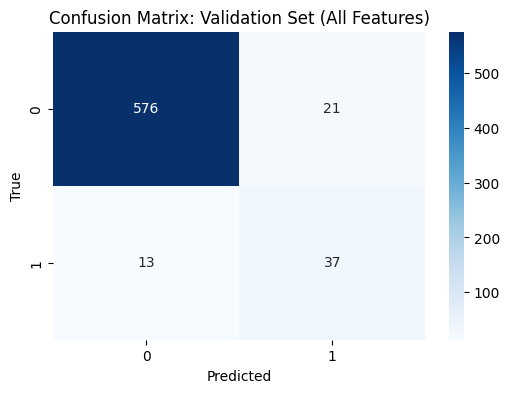

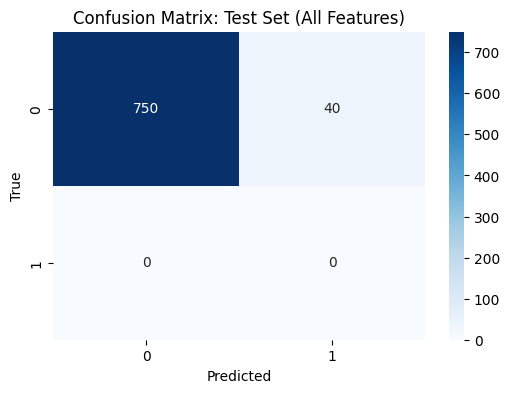

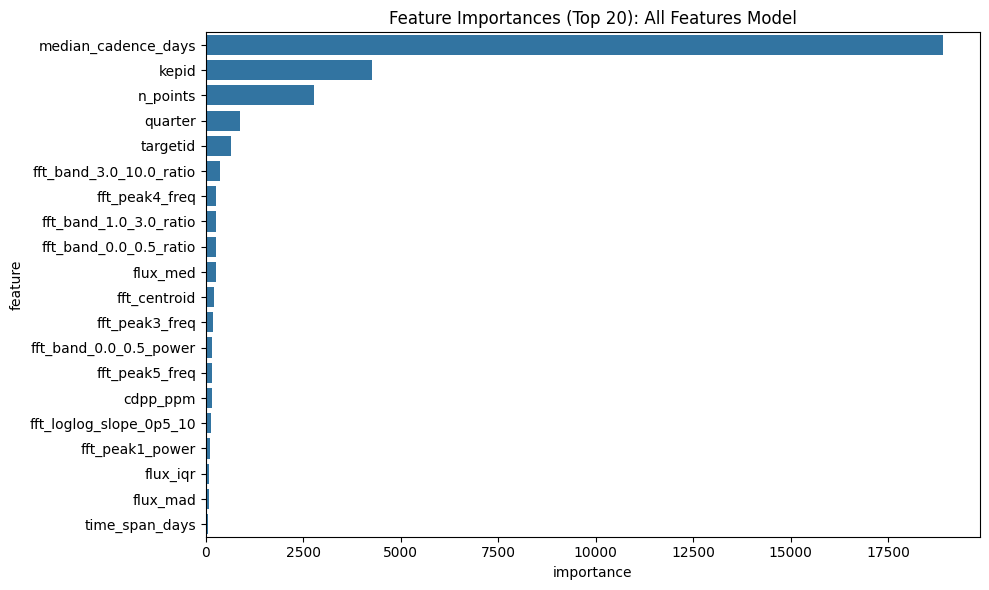

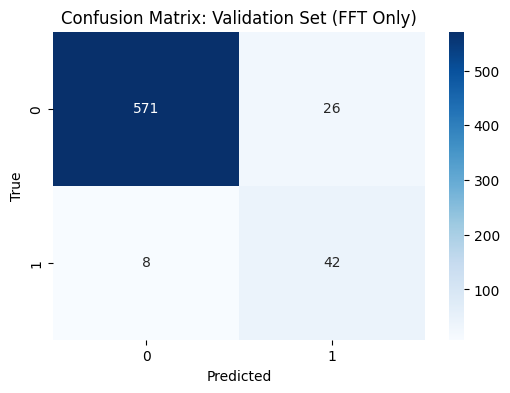

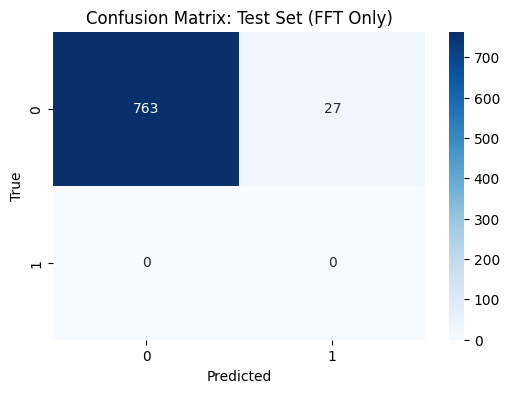

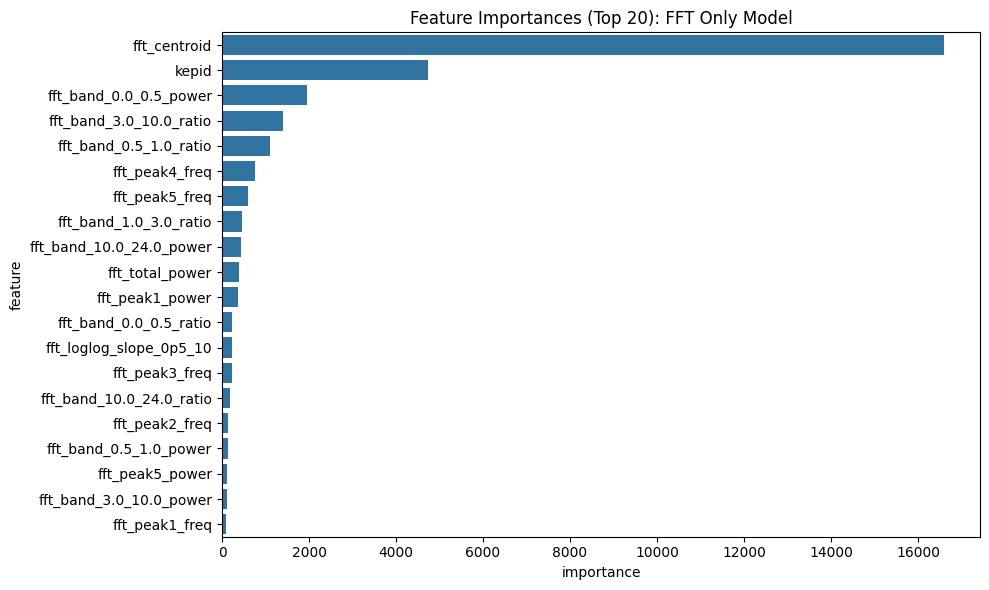

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

def plot_feature_importances(model, title):
    importances = model.feature_importance(importance_type='gain')
    feature_names = model.feature_name() # Get feature names directly from the model
    feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_imp = feature_imp.sort_values('importance', ascending=False).head(20) # Top 20 features

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_imp)
    plt.title(f'Feature Importances (Top 20): {title}')
    plt.tight_layout()
    plt.show()

# Assuming y_valid, y_test, model_all, X_valid, X_test are available from previous cells
# You might need to re-run the training cell if these variables are not in scope

# Get predictions for plotting
yhat_valid_all = (model_all.predict(X_valid_all, num_iteration=model_all.best_iteration) >= 0.5).astype(int)
yhat_test_all = (model_all.predict(X_test_all, num_iteration=model_all.best_iteration) >= 0.5).astype(int)

# Plot confusion matrices
plot_confusion_matrix(y_valid_all, yhat_valid_all, "Validation Set (All Features)")
plot_confusion_matrix(y_test_all, yhat_test_all, "Test Set (All Features)")

# Plot feature importances
plot_feature_importances(model_all, "All Features Model")

# If you also want to plot for the FFT-only model (assuming model_fft and X_fft_only are available)
yhat_valid_fft = (model_fft.predict(X_valid_fft, num_iteration=model_fft.best_iteration) >= 0.5).astype(int) # Need X_valid_fft
yhat_test_fft = (model_fft.predict(X_test_fft, num_iteration=model_fft.best_iteration) >= 0.5).astype(int) # Need X_test_fft
plot_confusion_matrix(y_valid_fft, yhat_valid_fft, "Validation Set (FFT Only)") # Need y_valid_fft
plot_confusion_matrix(y_test_fft, yhat_test_fft, "Test Set (FFT Only)") # Need y_test_fft
plot_feature_importances(model_fft, "FFT Only Model")

In [40]:
import pickle
import os

# Ensure the exports directory exists
os.makedirs('/content/exports', exist_ok=True)

# Export the model using pickle
model_path = '/content/exports/lightgbm_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_all, f)

print(f"Model exported successfully to {model_path}")

Model exported successfully to /content/exports/lightgbm_model.pkl


In [43]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the exports directory exists
exports_dir = '/content/exports'
model_path = '/content/exports/lightgbm_model.pkl'

# --- 1. Load the pickled model ---
try:
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    print(f"Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Please run cell EcmMQg6ExAx1 first to export the model.")
    loaded_model = None
except Exception as e:
    print(f"Error loading model: {e}")
    loaded_model = None

if loaded_model:
    # --- 2. Specify the path to a .fits file ---
    # Replace with the actual path to a .fits file you want to classify
    # You can find paths in the 'dataset_index' DataFrame if it's still in memory
    # For example, you could pick one from X_test_all or X_valid_all
    sample_fits_path = '/content/kepler_data/kepler_lightcurves/kplr001429345-2009350155506_llc.fits' # Example path

    # --- 3. Read the FITS file and extract features ---
    try:
        # Reuse the feature extraction functions defined earlier (make sure cell b-1_wR_sN6SI is run)
        lc, base_meta = read_lc_with_lightkurve(sample_fits_path)
        feats_fft = compute_fft_features(lc.time.value, lc.flux.value, min_pts=64, pad_factor=4)
        feats_meta = lightkurve_meta_features(lc)

        if feats_fft is None:
             print(f"Could not extract enough features from {sample_fits_path} for prediction.")
        else:
            # Create a DataFrame for the single sample, matching the training features
            # Need to ensure column order and names match the training data X_all
            feature_row = {}
            feature_row.update(base_meta)
            feature_row.update(feats_meta)
            feature_row.update(feats_fft)

            # Convert to DataFrame and ensure correct column order and dtypes
            # Get feature names from the loaded model to ensure consistency
            model_feature_names = loaded_model.feature_name()
            sample_X = pd.DataFrame([feature_row]).reindex(columns=model_feature_names).fillna(0) # Fill missing with 0 or median from training

            # --- 4. Make a prediction ---
            # predict_proba returns probabilities for each class [prob_class_0, prob_class_1]
            probabilities = loaded_model.predict(sample_X, num_iteration=loaded_model.best_iteration)[0]
            is_exoplanet_prob = probabilities[1] # Probability of being class 1 (exoplanet)
            prediction = is_exoplanet_prob >= 0.5 # Classify based on 0.5 threshold

            print(f"\nClassification for {sample_fits_path}:")
            print(f"Predicted is_exoplanet: {bool(prediction)}")
            print(f"Confidence Score (Probability of being exoplanet): {is_exoplanet_prob:.4f}")

            # --- Optional: Plot the lightcurve ---
            plt.figure(figsize=(10, 4))
            plt.plot(lc.time.value, lc.flux.value, '.', markersize=1)
            plt.xlabel('Time')
            plt.ylabel('Flux')
            plt.title(f'Lightcurve for {sample_fits_path.split("/")[-1]}')
            plt.tight_layout()
            plt.show()

    except NameError:
        print("Error: Feature extraction functions (read_lc_with_lightkurve, compute_fft_features, lightkurve_meta_features) not found.")
    except FileNotFoundError:
         print(f"Error: FITS file not found at {sample_fits_path}")
    except Exception as e:
        print(f"Error processing FITS file: {e}")

Model loaded successfully from /content/exports/lightgbm_model.pkl
Error processing FITS file: invalid index to scalar variable.


Model loaded successfully from /content/exports/lightgbm_model.pkl

Classification for /content/kepler_data/kepler_lightcurves/kplr001429345-2009350155506_llc.fits:
Predicted is_exoplanet: False
Confidence Score (Probability of being exoplanet): 0.0000
(Confidence score is the predicted probability of being an exoplanet. A score near 0 means the model is confident it's NOT an exoplanet.)


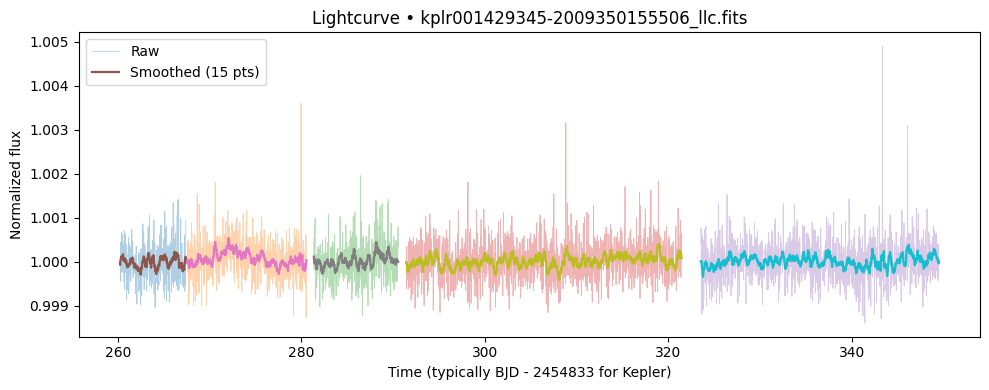

In [48]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the exports directory exists and model file path is correct
model_path = '/content/exports/lightgbm_model.pkl'

# --- 1. Load the pickled model ---
loaded_model = None
try:
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    print(f"Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Please ensure cell EcmMQg6ExAx1 was run to export the model.")
except Exception as e:
    print(f"Error loading model: {e}")

if loaded_model:
    # --- 2. Specify the path to a .fits file ---
    # Replace with the actual path to a .fits file you want to classify
    # You can find paths in the 'dataset_index' DataFrame if it's still in memory
    # For example, you could pick one from X_test_all or X_valid_all
    sample_fits_path = '/content/kepler_data/kepler_lightcurves/kplr001429345-2009350155506_llc.fits' # Example path

    # --- 3. Read the FITS file and extract features ---
    try:
        # Ensure feature extraction functions are defined (run cell b-1_wR_sN6SI)
        # Assuming read_lc_with_lightkurve, compute_fft_features, lightkurve_meta_features are available
        lc, base_meta = read_lc_with_lightkurve(sample_fits_path)

        if lc is None or len(lc.time) == 0:
            print(f"Could not load a valid lightcurve from {sample_fits_path}.")
        else:
            feats_fft = compute_fft_features(lc.time.value, lc.flux.value, min_pts=64, pad_factor=4)
            feats_meta = lightkurve_meta_features(lc)

            if feats_fft is None:
                 print(f"Could not extract enough features from {sample_fits_path} for prediction (min_pts not met).")
            else:
                # Create a DataFrame for the single sample, matching the training features
                # Need to ensure column order and names match the training data X_all
                feature_row = {}
                feature_row.update(base_meta)
                feature_row.update(feats_meta)
                feature_row.update(feats_fft)

                # Convert to DataFrame and ensure correct column order and dtypes
                # Get feature names from the loaded model to ensure consistency
                model_feature_names = loaded_model.feature_name()
                sample_X = pd.DataFrame([feature_row]).reindex(columns=model_feature_names).fillna(0) # Fill missing with 0 or median from training

                # --- 4. Make a prediction ---
                # predict_proba returns probabilities for each class [prob_class_0, prob_class_1]
                # LightGBM's predict returns raw scores for binary, not probabilities by default
                # Use predict_proba or set objective to 'binary' and use sigmoid if needed, but predict with objective 'binary' is usually fine
                # Let's assume predict directly gives the positive class probability for binary objective
                probabilities = loaded_model.predict(sample_X, num_iteration=loaded_model.best_iteration)[0]
                # If the objective is 'binary', predict returns probabilities for class 1
                is_exoplanet_prob = probabilities # Probability of being class 1 (exoplanet)
                prediction = is_exoplanet_prob >= 0.5 # Classify based on 0.5 threshold

                print(f"\nClassification for {sample_fits_path}:")
                print(f"Predicted is_exoplanet: {bool(prediction)}")
                print(f"Confidence Score (Probability of being exoplanet): {is_exoplanet_prob:.4f}")
                print("(Confidence score is the predicted probability of being an exoplanet. A score near 0 means the model is confident it's NOT an exoplanet.)")


                # --- Optional: Plot the lightcurve (raw + smoothed) ---
                plt.figure(figsize=(10, 4))

                # Use smoothing logic from cell ZCgwvvvPI2gx
                def smooth_moving_average(y, window_pts=11):
                    """Centered moving average that handles NaNs gracefully."""
                    window_pts = int(max(3, window_pts))
                    if window_pts % 2 == 0:  # prefer odd window for centered smoothing
                        window_pts += 1
                    return pd.Series(y).rolling(window_pts, center=True, min_periods=max(1, window_pts//2)).mean().to_numpy()

                def segment_by_gaps(x, max_gap=None):
                    """Split index array where time gaps are large to avoid misleading lines."""
                    if len(x) < 2:
                        return [np.arange(len(x))]
                    dx = np.diff(x)
                    if max_gap is None:
                        # treat anything > 5× median cadence as a gap
                        med = np.nanmedian(dx) if np.isfinite(dx).any() else 0
                        max_gap = 5 * med if med > 0 else np.inf
                    breaks = np.where(dx > max_gap)[0] + 1
                    return np.split(np.arange(len(x)), breaks)


                t = lc.time.value
                f = lc.flux.value

                # Normalize (keeps units tidy for plotting)
                f_norm = f / np.nanmedian(f) if np.nanmedian(f) != 0 else f

                # Pick a small smoothing scale automatically (~0.3 day span by default)
                target_span_days = 0.3
                cad = np.nanmedian(np.diff(t)) if len(t) > 1 else np.nan
                if np.isfinite(cad) and cad > 0:
                    window_pts = int(round(target_span_days / cad))
                else:
                    window_pts = 11
                window_pts = max(5, window_pts | 1)  # odd & not too small

                f_smooth = smooth_moving_average(f_norm, window_pts=window_pts)


                # raw line (light)
                for idx in segment_by_gaps(t):
                    if len(idx) > 1:
                        plt.plot(t[idx], f_norm[idx], linewidth=0.6, alpha=0.35, label='Raw' if idx[0] == 0 else "")

                # smoothed line (emphasis)
                for idx in segment_by_gaps(t):
                    if len(idx) > 1:
                        plt.plot(t[idx], f_smooth[idx], linewidth=1.6, label=f'Smoothed ({window_pts} pts)' if idx[0] == 0 else "")


                plt.xlabel('Time (typically BJD - 2454833 for Kepler)')
                plt.ylabel('Normalized flux')
                plt.title(f'Lightcurve • {sample_fits_path.split("/")[-1]}')
                plt.legend()
                plt.tight_layout()
                plt.show()

    except NameError:
        print("Error: Feature extraction or smoothing functions not found.")
        print("Please run the cells containing these function definitions (e.g., cell b-1_wR_sN6SI, ZCgwvvvPI2gx) before running this code.")
    except FileNotFoundError:
         print(f"Error: FITS file not found at {sample_fits_path}")
    except Exception as e:
        print(f"Error processing FITS file: {e}")
        traceback.print_exc() # Print traceback for debugging

# Task
Clean up the notebook by removing redundant imports and unused code.

## Identify redundant imports

### Subtask:
Go through each code cell and identify import statements that are duplicated or for libraries that are not used in that cell or subsequent cells.


## Remove redundant imports and unused code

### Subtask:
Remove redundant import statements and unused code blocks or variables from the notebook.
